In [ ]:
!pip3 install trfl

In [1]:
import random
import scipy as sp
from keras.layers import Dense, K
from keras.models import Sequential, load_model
import numpy as np
from scipy import misc
import pickle
import math
import matplotlib.pyplot as plt
import trfl
import queue
import sys
import os
from collections import defaultdict
import tensorflow as tf
from collections import deque
import collections


Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# Some parameters
target_update_interval = 1000
training = False
history_length = 10
max_steps = 50

In [3]:
# Some functions to get states, actions and rewards


def crop_image(bb, image):

    w, h, d = image.shape
    bb = [int(math.floor(b)) for b in bb]
    bb[0] = max(bb[0], 0)
    bb[1] = max(bb[1], 0)
    bb[2] = min(bb[2], h)
    bb[3] = min(bb[3], w)
    cropped = image[bb[1]:bb[3], bb[0]:bb[2]]
    w, h, d = cropped.shape
    if w == 0 or h == 0:
        cropped = np.zeros((224, 224, 3))
    else:
        cropped = sp.misc.imresize(cropped, (224, 224, 3), interp='bilinear')
    return cropped


def get_unique_indices(labels):
    return [i for i in range(len(labels)) if len(labels[i]) == 1]


def flatten(arr):
    return [item for sublist in arr for item in sublist]


def intersection_area(boxA, boxB):
    dx = min(boxA[2], boxB[2]) - max(boxA[0], boxB[0])
    dy = min(boxA[3], boxB[3]) - max(boxA[1], boxB[1])
    if (dx >= 0) and (dy >= 0):
        return dx * dy
    return 0


def iou(boxA, boxB):
    inter = intersection_area(boxA, boxB)
    if inter == 0:
        return 0
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / (areaA + areaB - inter)

class State:
    cnn_model = load_model(os.path.join("","vgg16.h5"))
    feature_extractor = K.function([cnn_model.layers[0].input], [cnn_model.layers[20].output])

    def __init__(self, history, bb, image):
        self.history = history
        self.bb = bb
        self.feature = State.compute_feature(history, bb, image)

    @staticmethod
    def compute_feature(history, bb, image):
        history_feature = State.get_history_feature(history)
        image_feature = State.get_image_feature(image, bb)
        feature = np.concatenate((image_feature, history_feature))
        return np.array(feature)

    @staticmethod
    def get_image_feature(image, bb):
        cropped = crop_image(bb, image)
        feature = State.feature_extractor([cropped.reshape(1, 224, 224, 3)])[0]
        return np.ndarray.flatten(feature)

    @staticmethod
    def get_history_feature(history):
        assert len(history) == history_length
        feature = np.zeros((90,))
        for i in range(history_length):
            action = history[i]
            if action != -1:
                feature[i * 9 + action] = 1
        return feature

    
def transform(bb, a):

    alpha = .2
    alpha_w = alpha * (bb[2] - bb[0])
    alpha_h = alpha * (bb[3] - bb[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if a == 0:
        dx1 = alpha_w
        dx2 = alpha_w
    elif a == 1:
        dx1 = -alpha_w
        dx2 = -alpha_w
    elif a == 2:
        dy1 = alpha_h
        dy2 = alpha_h
    elif a == 3:
        dy1 = -alpha_h
        dy2 = -alpha_h
    elif a == 4:
        dx1 = -alpha_w
        dx2 = alpha_w
        dy1 = -alpha_h
        dy2 = alpha_h
    elif a == 5:
        dx1 = alpha_w
        dx2 = -alpha_w
        dy1 = alpha_h
        dy2 = -alpha_h
    elif a == 6:
        dy1 = alpha_h
        dy2 = -alpha_h
    elif a == 7:
        dx1 = alpha_w
        dx2 = -alpha_w

    bb = (bb[0] + dx1, bb[1] + dy1, bb[2] + dx2, bb[3] + dy2)
    bb = (
        min(bb[0], bb[2]),
        min(bb[1], bb[3]),
        max(bb[0], bb[2]),
        max(bb[1], bb[3]),
    )

    return bb

def trigger_reward(bb, true_bb):
    return 3 if iou(bb, true_bb) > .5 else -3


def transform_reward(bb, bbp, true_bb):
    return 1 if iou(bbp, true_bb) > iou(bb, true_bb) else -1

def take_action(s, true_bb, a, image):

    if a == 8:
        sp = s
        r = trigger_reward(s.bb, true_bb)
        took_trigger = True

    else:

        bb = s.bb
        bbp = transform(bb, a)
        r = transform_reward(bb, bbp, true_bb)
        took_trigger = False
        historyp = s.history[1:]
        historyp.append(a)
        assert len(historyp) == history_length
        sp = State(historyp, bbp, image)

    return sp, r, took_trigger

def select_action(s, true_bb, step):

    if step == max_steps:
        a = 8

    else:
        action_rewards = [transform_reward(s.bb, transform(s.bb, a_tmp), true_bb) for a_tmp in range(8)]
        action_rewards.append(trigger_reward(s.bb, true_bb))
        action_rewards = np.array(action_rewards)
        positive_action_indices = np.where(action_rewards >= 0)[0]

        if len(positive_action_indices) == 0:
            positive_action_indices = list(range(0, 9))
        a = np.random.choice(positive_action_indices)


    return a

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def load_data(filter_ratio, training_ratio, load_only_one=False):
    global images
    bbs = pickle.load(open(os.path.join("", "bounding_boxes.p"), "rb"))
    print('loaded bbs')

    labels = pickle.load(open(os.path.join("", "labels_rl.p"), "rb"))
    print('loaded labels')

    unique_indices = get_unique_indices(labels)
    indices_to_load = unique_indices[:int(len(unique_indices) * filter_ratio)]

    if load_only_one:
        indices_to_load = [unique_indices[0]]

    bbs = [bbs[i][0] for i in indices_to_load]
    labels = [labels[i] for i in indices_to_load]
    images = [sp.misc.imread(os.path.join("", "out_rl", str(i) + ".png")) for i in indices_to_load]

    bbs_train = bbs[:int(len(bbs) * training_ratio)]
    bbs_test = bbs[int(len(bbs) * training_ratio):]

    labels_train = labels[:int(len(labels) * training_ratio)]
    labels_test = labels[int(len(labels) * training_ratio):]

    images_train = images[:int(len(images) * training_ratio)]
    images_test = images[int(len(images) * training_ratio):]


    if load_only_one:

        bbs_train = flatten([bbs for i in range(1000)])
        labels_train = flatten([labels for i in range(1000)])
        images_train = flatten([images for i in range(1000)])

    return bbs_train, bbs_test, labels_train, labels_test, images_train, images_test, indices_to_load

In [4]:
load_only_one = True
filter_ratio = 1.0
training_ratio = .8
bbs_train, bbs_test, labels_train, labels_test, images_train, images_test, indices_to_load = load_data(filter_ratio,
                                                                                                       training_ratio,
                                                                                                       load_only_one)

print('images loaded')

loaded bbs
loaded labels
images loaded


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4186, 
                 action_size=9, hidden_size=1024, batch_size=20,
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            #one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            #self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            self.name = name
            
            #Non trfl way from tutorial: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

            #TRFL way
            self.targetQs_ = tf.placeholder(tf.float32, [batch_size,action_size], name='target')
            self.reward = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount = tf.constant(0.1,shape=[batch_size],dtype=tf.float32,name="discount")
      
            #TRFL qlearning
            qloss, q_learning = trfl.double_qlearning(self.output,self.actions_,self.reward,self.discount,self.targetQs_,self.output)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
    

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=True)
        return [self.buffer[ii] for ii in idx]

In [7]:
train_episodes = 15          # max number of episodes to learn from
max_steps = 50                # max steps in an episode
gamma = .1                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.1            # minimum exploration probability 
decay_rate = (explore_start - explore_stop)/10            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 1024               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 3000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size

In [19]:
tf.reset_default_graph()

In [8]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.


In [9]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.name)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.name)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)

In [25]:
image = images_train[1]
bbs = bbs_train[1]
label = labels_train[1]
index = 1
(width, height, d) = image.shape
print(width, height, d)
initial_history = [-1] * history_length
initial_bb = (0, 0, height, width)

s = State(initial_history, initial_bb, image)
state = s.feature
true_bb = bbs
done = False
memory = Memory(max_size=memory_size)

500 359 3


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [28]:
# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action_rewards = [transform_reward(s.bb, transform(s.bb, a_tmp), true_bb) for a_tmp in range(8)]
    action_rewards.append(trigger_reward(s.bb, true_bb))
    action_rewards = np.array(action_rewards)
    positive_action_indices = np.where(action_rewards >= 0)[0]
    print("good actions",positive_action_indices)
    if len(positive_action_indices) == 0:
            positive_action_indices = list(range(0, 9))
            
    action = np.random.choice(positive_action_indices)
    print("action", action)
    next_s, reward, done = take_action(s, true_bb, action, image)
    print(reward, done)
    next_state = next_s.feature
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        break
        # Start new episode
        # Take one random step to get the pole and cart moving
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        s = next_s
        state = next_state

good actions [5 6 7]
action 5
1 False
good actions [1 2]
action 1
1 False
good actions [2]
action 2
1 False
good actions [6]
action 6
1 False
good actions [8]
action 8
3 True


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [10]:
load_only_one = False
filter_ratio = 1.0
training_ratio = .8
bbs_train, bbs_test, labels_train, labels_test, images_train, images_test, indices_to_load = load_data(filter_ratio,
                                                                                                       training_ratio,
                                                                                                       load_only_one)

print('images loaded')

loaded bbs
loaded labels


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


images loaded


In [10]:
print(len(bbs_train))

7172


In [11]:
memory = Memory(max_size=memory_size)

In [ ]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    total_steps = 0
    for ep in range(0, train_episodes):
        explore_p = explore_start -ep * decay_rate
        if explore_p < 0.1:
            explore_p = 0.1
        image_count = 0
        for image, true_bb, label in zip(images_train, bbs_train, labels_train):
            (width, height, d) = image.shape
            initial_history = [-1] * history_length
            initial_bb = (0, 0, height, width)
            s = State(initial_history, initial_bb, image)
            state = s.feature
            image_count += 1
            total_reward = 0
            t = 0
            while t < max_steps: # problem of max steps
                # Uncomment this next line to watch the training
                # env.render() 
                # Explore or Exploit
                total_steps += 1
                if total_steps % target_update_interval == 0:
                    copy_model_parameters(sess, mainQN, targetQN)
                    print("\nCopied model parameters to target network.")
                
                
                if explore_p > np.random.rand():
                    # Make a random action
                    action = select_action(s, true_bb, t)
                else:
                    # Get action from Q-network

                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)
                
                # Take action, get new state and reward
                next_s, reward, done = take_action(s, true_bb, action, image)
                next_state = next_s.feature
                total_reward += reward
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros(state.shape)
                    t = max_steps

                    print('Episode: {}'.format(ep),
                          'Image number: {}'.format(image_count),
                          'Total reward: {}'.format(total_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p))

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    break
    #                 action = np.random.choice(list(range(0, 8)))
    #                 s, reward, done = take_action(s, true_bb, action, image)
    #                 state = np.concatenate((next_s.history_feature, next_s.image_feature))
                    # Start new episode
                    # Take one random step to get the pole and cart moving

                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    s = next_s
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network
                target_Qs = sess.run(targetQN.output, feed_dict={targetQN.inputs_: next_states})
                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = (0, 0, 0, 0, 0, 0, 0, 0, 0)

                #tutorial way
                #targets = rewards + gamma * np.max(target_Qs, axis=1)
    #             loss, _ = sess.run([mainQN.loss, mainQN.opt],
    #                                 feed_dict={mainQN.inputs_: states,
    #                                            mainQN.targetQs_: targets,
    #                                            mainQN.actions_: actions})

                #TRFL way, calculate td_error within TRFL
                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: target_Qs,
                                               mainQN.reward: rewards,
                                               mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole_1.ckpt")

/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Episode: 0 Image number: 1 Total reward: 8 Training loss: 2.4885 Explore P: 1.0000
Episode: 0 Image number: 2 Total reward: 5 Training loss: 0.6631 Explore P: 1.0000
Episode: 0 Image number: 3 Total reward: 3 Training loss: 0.6631 Explore P: 1.0000
Episode: 0 Image number: 4 Total reward: 10 Training loss: 0.1584 Explore P: 1.0000
Episode: 0 Image number: 5 Total reward: 3 Training loss: 0.1584 Explore P: 1.0000
Episode: 0 Image number: 6 Total reward: 3 Training loss: 0.1584 Explore P: 1.0000
Episode: 0 Image number: 7 Total reward: 3 Training loss: 0.1584 Explore P: 1.0000
Episode: 0 Image number: 8 Total reward: 3 Training loss: 0.1584 Explore P: 1.0000
Episode: 0 Image number: 9 Total reward: 13 Training loss: 0.1054 Explore P: 1.0000
Episode: 0 Image number: 10 Total reward: 6 Training loss: 0.2425 Explore P: 1.0000
Episode: 0 Image number: 11 Total reward: 11 Training loss: 0.1433 Explore P: 1.0000
Episode: 0 Image number: 12 Total reward: 5 Training loss: 0.2129 Explore P: 1.000

In [ ]:
with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "checkpoints/cartpole.ckpt")
    print("Model restored.")
  # Check the values of the variables
    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
    Qs = sess.run(mainQN.output, feed_dict=feed)
    print(Qs)

In [13]:
results = []
action_number = {}
for i in range(1,101):
    action_number[i] = 0
with tf.Session() as sess:
    count = 0
    saver.restore(sess, "checkpoints/cartpole.ckpt")
    for image, true_bb in zip(images_test, bbs_test):
        (width, height, d) = image.shape
        initial_history = [-1] * history_length
        initial_bb = (0, 0, height, width)
        s = State(initial_history, initial_bb, image)
        state = s.feature
        done = False
        step = 0
        for i in range(max_steps):
            feed = {mainQN.inputs_:state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict = feed)
            
            if i == max_steps-1:
                action = 8

            else:
                action = np.argmax(Qs)
            if action == 8:
                next_s = s
                done = True

            else:
                bbp = transform(s.bb, action)
                historyp = s.history[1:]
                historyp.append(action)
                assert len(historyp) == history_length
                next_s = State(historyp, bbp, image)
                s = next_s
                state = next_s.feature
            if done:
                step = i+1
                action_number[step] += 1
                break
        count+=1
        print("image ",count," predicted", "step: ",step )
        results.append(s.bb)

inds = range(int(len(images) * training_ratio), len(images))       
np.savetxt("predicted_bounding_boxes_Ddqn.csv", results, delimiter=',', newline='\n')
np.savetxt("predicted_image_indices.csv", inds, delimiter=',', newline='\n')
np.savetxt("predicted_image_labels.csv", labels_test, delimiter=',', newline='\n')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/cartpole_1.ckpt


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff8da894208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


image  1  predicted step:  82
image  2  predicted step:  12
image  3  predicted step:  100
image  4  predicted step:  27
image  5  predicted step:  35
image  6  predicted step:  10
image  7  predicted step:  12
image  8  predicted step:  24
image  9  predicted step:  35
image  10  predicted step:  64
image  11  predicted step:  31
image  12  predicted step:  100
image  13  predicted step:  21
image  14  predicted step:  60
image  15  predicted step:  25
image  16  predicted step:  13
image  17  predicted step:  100
image  18  predicted step:  35
image  19  predicted step:  100
image  20  predicted step:  10
image  21  predicted step:  12
image  22  predicted step:  37
image  23  predicted step:  55
image  24  predicted step:  59
image  25  predicted step:  100
image  26  predicted step:  100
image  27  predicted step:  20
image  28  predicted step:  34
image  29  predicted step:  100
image  30  predicted step:  70
image  31  predicted step:  38
image  32  predicted step:  36
image  33 

dict_values([56, 30, 1, 39, 17, 42, 28, 20, 28, 45, 15, 95, 52, 31, 34, 37, 32, 30, 20, 21, 28, 31, 26, 26, 30, 25, 25, 22, 28, 10, 28, 18, 15, 22, 15, 18, 18, 19, 12, 10, 12, 10, 15, 20, 19, 10, 9, 7, 6, 12, 9, 8, 8, 10, 5, 5, 8, 7, 8, 7, 7, 9, 9, 6, 11, 3, 4, 2, 6, 8, 4, 6, 4, 7, 1, 6, 6, 3, 0, 2, 4, 10, 2, 2, 4, 1, 3, 3, 2, 1, 1, 3, 2, 2, 1, 3, 2, 1, 1, 348])


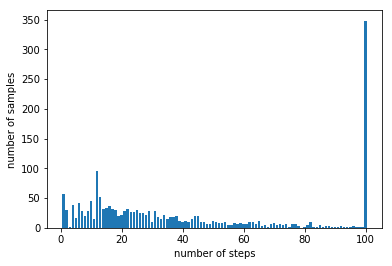

In [17]:
import matplotlib.pyplot as plot
print(action_number.values())
plt.bar(range(1,101), list(action_number.values())[0:100])

plot.xlabel('number of steps')
plot.ylabel('number of samples')
plot.savefig("ddqn_steps.png")

In [19]:
CLASSES = ["person", "bird", "cat", "cow", "dog", "horse", "sheep", "aeroplane", "bicycle", "boat", "bus", "car",
           "motorbike", "train", "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]
def get_features(images, bbs, labels):
    
    feature_to_all = []
    
    for xi, yi, l, data_index in zip(images, bbs, labels, range(len(images_train))):
        (width, height, d) = xi.shape
        initial_history = [-1] * history_length
        initial_bb = (0, 0, height, width)
        s = State(initial_history, initial_bb, xi)
        feature = s.get_image_feature(xi, yi)
        feature_to_all.append(feature)
        
    return feature_to_all

import csv
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from collections import OrderedDict 
from sklearn.externals import joblib

feature_train = []
with open('All_features.csv') as f:
    feature = csv.reader(f, delimiter=',')
    for row in feature:
        feature_train.append([float(i) for i in row])
        
label_train = []
with open('image_names.csv') as f:
    label = csv.reader(f, delimiter=',')
    for row in label:
        label_train.append([float(i) for i in row])

#label_train = np.ndarray.flatten(np.array(label_train))
svm = LinearSVC()
svm.fit(feature_train, label_train)
print("fit completed")

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit completed


In [22]:
predict_bbs = []
with open('predicted_bounding_boxes.csv') as f:
    bbs = csv.reader(f, delimiter=',')
    for row in bbs:
        predict_bbs.append([float(i) for i in row])
        
predict_feature = get_features(images_test, predict_bbs, labels_test)

ground_truth = get_features(images_test, bbs_test, labels_test)

label_DeepQ = svm.predict(predict_feature)

label_ground = svm.predict(ground_truth)
accuracy_predict = OrderedDict()
accuracy_ground = OrderedDict()
sum_correct_predict = []
sum_correct_ground = []

labels_test = np.array(labels_test)    
for i in range(20):
    unique, counts = np.unique(labels_test, return_counts=True)
    count = dict(zip(unique, counts))[i]
    indexes = np.where(labels_test == i)[0]
    unique1, counts1 = np.unique(label_DeepQ[indexes], return_counts=True)
    count_predict = dict(zip(unique1, counts1))[i]
    unique2, counts2 = np.unique(label_ground[indexes], return_counts=True)
    count_ground = dict(zip(unique2, counts2))[i]
    sum_correct_predict.append(count_predict)
    sum_correct_ground.append(count_ground)
    accuracy_predict[CLASSES[i]] = count_predict/count
    accuracy_ground[CLASSES[i]] = count_ground/count   
    
total_accu_predict = sum(sum_correct_predict)/len(labels_test)
total_accu_ground = sum(sum_correct_ground)/len(labels_test)
print('accuracy of predicted bounding boxes of test data in SVM:', accuracy_predict)
print('accuracy of ground truth bounding boxes of test data in SVM:', accuracy_ground)
print('accuracy of total correct classification for prediction = ', total_accu_predict)
print('accuracy of total correct classification for ground truth = ', total_accu_ground)
print("relative:")
print([x/y for x,y in zip(accuracy_predict.values(), accuracy_ground.values())])

/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


accuracy of predicted bounding boxes of test data in SVM: OrderedDict([('person', 0.8713789107763615), ('bird', 0.6864406779661016), ('cat', 0.8581081081081081), ('cow', 0.76), ('dog', 0.7794117647058824), ('horse', 0.5909090909090909), ('sheep', 0.5833333333333334), ('aeroplane', 0.6896551724137931), ('bicycle', 0.5581395348837209), ('boat', 0.6), ('bus', 0.5294117647058824), ('car', 0.5606060606060606), ('motorbike', 0.6666666666666666), ('train', 0.7123287671232876), ('bottle', 0.45454545454545453), ('chair', 0.5172413793103449), ('diningtable', 0.8), ('pottedplant', 0.625), ('sofa', 0.5882352941176471), ('tvmonitor', 0.9444444444444444)])
accuracy of ground truth bounding boxes of test data in SVM: OrderedDict([('person', 0.9976825028968713), ('bird', 0.9576271186440678), ('cat', 0.9864864864864865), ('cow', 0.88), ('dog', 0.9705882352941176), ('horse', 0.9545454545454546), ('sheep', 1.0), ('aeroplane', 0.9885057471264368), ('bicycle', 0.9302325581395349), ('boat', 0.97142857142857

In [80]:
visualization = []
action_number = {}

with tf.Session() as sess:
    count = 0
    saver.restore(sess, "checkpoints/cartpole.ckpt")
    for image, true_bb, label in zip(images_test, bbs_test, labels_test):
        action_history = []
        bb_history = []
        (width, height, d) = image.shape
        initial_history = [-1] * history_length
        initial_bb = (0, 0, height, width)
        bb_history.append(initial_bb)
        s = State(initial_history, initial_bb, image)
        state = s.feature
        done = False
        step = 0
        for i in range(max_steps):
            feed = {mainQN.inputs_:state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict = feed)
            
            if i == max_steps-1:
                action = 8

            else:
                action = np.argmax(Qs)
            if action == 8:
                next_s = s
                done = True
                action_history.append(action)

            else:
                bbp = transform(s.bb, action)
                historyp = s.history[1:]
                historyp.append(action)
                bb_history.append(bbp)
                action_history.append(action)
                assert len(historyp) == history_length
                next_s = State(historyp, bbp, image)
                s = next_s
                state = next_s.feature
            if done:
                if iou(true_bb, s.bb) >= 0.7 and i <= 10 and i >=2 and label[0]!=0:
                    visualization.append({"action":action_history, "bb":bb_history, "ins":count, "true_bb":true_bb})
                    
                    print('found one!')
                step = i+1
                break
        if len(visualization) >=5:
            break
        count+=1
        print("image ",count," predicted", "step: ",step )
        results.append(s.bb)

inds = range(int(len(images) * training_ratio), len(images))   

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


/home/hy2574/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff8d8a87080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


image  1  predicted step:  1
image  2  predicted step:  2
image  3  predicted step:  1
image  4  predicted step:  3
image  5  predicted step:  1
image  6  predicted step:  5
image  7  predicted step:  7
image  8  predicted step:  4
image  9  predicted step:  2
image  10  predicted step:  3
image  11  predicted step:  2
image  12  predicted step:  33
image  13  predicted step:  2
image  14  predicted step:  40
image  15  predicted step:  1
image  16  predicted step:  7
image  17  predicted step:  1
image  18  predicted step:  2
image  19  predicted step:  3
image  20  predicted step:  2
image  21  predicted step:  2
image  22  predicted step:  2
image  23  predicted step:  1
image  24  predicted step:  5
image  25  predicted step:  1
image  26  predicted step:  40
image  27  predicted step:  2
image  28  predicted step:  1
image  29  predicted step:  1
image  30  predicted step:  1
image  31  predicted step:  1
image  32  predicted step:  2
image  33  predicted step:  1
image  34  predi

In [81]:
print(visualization)

[{'bb': [(0, 0, 500, 375), (100.0, 75.0, 400.0, 300.0), (40.0, 30.0, 460.0, 345.0)], 'action': [5, 4, 8], 'true_bb': (4, 37, 500, 373), 'ins': 82}, {'bb': [(0, 0, 375, 500), (75.0, 100.0, 300.0, 400.0), (30.0, 40.0, 345.0, 460.0)], 'action': [5, 4, 8], 'true_bb': (1, 1, 375, 481), 'ins': 141}, {'bb': [(0, 0, 500, 332), (100.0, 66.4, 400.0, 265.6), (40.0, 26.560000000000002, 460.0, 305.44000000000005)], 'action': [5, 4, 8], 'true_bb': (1, 20, 500, 308), 'ins': 310}, {'bb': [(0, 0, 500, 335), (100.0, 67.0, 400.0, 268.0), (100.0, 107.2, 400.0, 308.2), (40.0, 67.0, 460.0, 348.4)], 'action': [5, 2, 4, 8], 'true_bb': (1, 15, 472, 335), 'ins': 342}, {'bb': [(0, 0, 500, 334), (100.0, 66.8, 400.0, 267.2), (160.0, 106.88, 340.0, 227.12), (124.0, 82.832, 376.0, 251.168)], 'action': [5, 5, 4, 8], 'true_bb': (135, 101, 399, 250), 'ins': 481}]


In [90]:
visual = visualization[4]
print(visual)

{'bb': [(0, 0, 500, 334), (100.0, 66.8, 400.0, 267.2), (160.0, 106.88, 340.0, 227.12), (124.0, 82.832, 376.0, 251.168)], 'action': [5, 5, 4, 8], 'true_bb': (135, 101, 399, 250), 'ins': 481}


In [91]:
import cv2
image = images_test[visual["ins"]]
true_bb = bbs_test[visual["ins"]]
ins = range(int(len(images) * training_ratio), len(images))[visual["ins"]]
xmin_t, ymin_t, xmax_t, ymaxt = true_bb 
count = 0
for predicted_bb in visual["bb"]:
    xmin, ymin, xmax, ymax = predicted_bb
    image = cv2.imread("out_rl/"+str(ins)+".png")
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3) 
    cv2.rectangle(image, (xmin_t, ymin_t), (xmax_t, ymaxt), (0, 0, 255),3)
    cv2.imwrite(str(ins)+"_"+str(count)+'.png', image)
    count+=1
